In [61]:
RELOAD_ALL = False
YEARS = ["2019", "2020", "2021", "2022"]

In [145]:
import pickle
import pandas as pd
import numpy as np

import sklearn
from sklearn.decomposition import NMF

def distill_topics(topics, nwords):
    topics = topics.where(topics > topics.replace(0.0, np.nan).quantile(0.25), np.nan)

    final = pd.DataFrame()
    for n, top in topics.T.iterrows():
        final[n] = top.drop(final.values.flatten(), axis=0).sort_values().dropna().tail(nwords).index

    return final

def get_word_vecs(aggf):
    word_vecs = aggf["Description"].map(
            lambda s: pd.Series(dict(eval(s[11:-1])), dtype="f8"))
    word_vecs = word_vecs.to_list()
    return word_vecs

def chunk_sets(ls, chunk_size=100):
    if len(ls) == 1:
        return ls
    out = []
    start = 0
    for end in range(chunk_size, len(ls)+chunk_size, chunk_size):
        chunk = ls[start:min(end, len(ls))]
        joined = pd.concat(chunk, axis=1)
        # joindex = set()
        # for c in chunk:
        #     joindex = set(c.index.tolist()).union(joindex)
        out.append(joined)
        start = end
    return out

def prune(chunked, low_limit=0.01, high_limit=0.7):
    out = []
    for chunk in chunked:
        chunk = chunk.drop(chunk.index[chunk.count(1) > chunk.shape[1] * high_limit], axis=0)
        chunk = chunk.drop(chunk.index[chunk.count(1) < chunk.shape[1] * low_limit], axis=0)
        out.append(chunk)
    return out

def chunk_and_prune(word_vecs, save_filename=None):
    print(f"Setting up chunk+prune...")
    chunked = chunk_sets(word_vecs)
    full_size = len(chunked)
    print(f"Chunking, {int((1 - len(chunked) / full_size) * 100)}% complete")
    while (len(chunked) > 1):
        chunked = chunk_sets(chunked, chunk_size=2)
        chunked = prune(chunked)
        print(f"Chunking, {int((1 - (len(chunked) - 1) / full_size) * 100)}% complete")

    if save_filename is not None:
        print("Writing to file")
        with open(save_filename, "wb") as f:
            pickle.dump(chunked[0].fillna(0.0), f)
    return chunked[0].fillna(0.0)

def extract_topics(word_mat, ncomp=8, nwords=15, strict_separation=False):
    deco = NMF(n_components=ncomp, init="nndsvd", l1_ratio=1.0).fit(word_mat.T)
    topics = pd.DataFrame(deco.components_.T, index=word_mat.index)

    if strict_separation:
        # stop words, uninteresting 
        return distill_topics(topics, nwords), topics
    return topics



In [2]:
if RELOAD_ALL:
    word_mats = {}
    tops = {}
    for year in YEARS:
        print(year)
        save_filename = year + "_all.pkl"
        data = pd.read_csv(year + "-data-merged.csv", index_col=[0])

        word_vecs = get_word_vecs(data)
        word_mats[year] = chunk_and_prune(word_vecs, save_filename)
        tops[year] = extract_topics(word_mats[year], strict_separation=False)
else:
    word_mats = {}
    tops = {}
    for year in ["2019", "2020", "2021", "2022"]:
        print(year)
        save_filename = year + "_all.pkl"
        with open(save_filename, "rb") as f:
            word_mats[year] = pickle.load(f)
        tops[year] = extract_topics(word_mats[year], ncomp=5, strict_separation=False)

2019
2020
2021
2022


In [117]:
master = "2021"
keys = ["2019", "2020", "2021", "2022"]

joindex = None
for key in keys:
    if joindex is None:
        joindex = word_mats[key].index
    else:
        joindex = joindex.union(word_mats[key].index)

In [118]:
agg_word_mats = pd.concat([word_mats[key].reindex(joindex) for key in keys], axis=1)

In [129]:
doc_freq = (agg_word_mats > 0.0).sum(0)
doc_freq = (-doc_freq + doc_freq.max()) / doc_freq.max()


In [130]:
tfidf = agg_word_mats.divide(agg_word_mats.sum(1), axis=0).multiply(doc_freq, axis=1)
tfidf.fillna(0.0, inplace=True)

In [157]:
tops_agg = extract_topics(tfidf, ncomp=5, strict_separation=False)

In [158]:
def make_corr(mat):
    diag = np.sqrt(np.diag(mat))
    mat /= diag[:, np.newaxis]
    mat /= diag[np.newaxis, :]
    return mat

In [159]:
make_corr((tops_agg.T @ tops_agg))

,0,1,2,3,4
0,1.000000,0.003009,0.009391,0.001307,0.028391
1,0.003009,1.000000,0.055220,0.005079,0.035270
2,0.009391,0.055220,1.000000,0.008853,0.081435
3,0.001307,0.005079,0.008853,1.000000,0.024257
4,0.028391,0.035270,0.081435,0.024257,1.000000


#### ^ Looks good!

In [176]:
distill_topics(tops_agg, 25)

,0,1,2,3,4
0,2,human,01,solution,shaft
1,feature,per,consist,free,open
2,n,together,ii,conductive,groove
3,cell,agent,weight,less,intermediate
4,material,6,100,wire,back
5,oxide,ring,10,c,accordance
6,pin,bond,5,semiconductor,movable
7,μm,amount,vector,resin,lock
8,voltage,patient,20,transistor,cavity
9,factor,mixture,50,concentration,series


In [192]:
# make up some names based on the above
master_keys = ["Battery", "Pharma", "Biotech", "Electrical", "Manufacturing"]

In [181]:
# compute document loadings
loadings = {key: word_mats[key].reindex(joindex).fillna(0.0).T @ tops_agg for key in keys}

In [182]:
dists = {key: loadings[key].divide(loadings[key].sum(1), axis=0).mean(axis=0) for key in keys}
dists = pd.concat(dists, axis=1)
dists.index = master_keys


<AxesSubplot:>

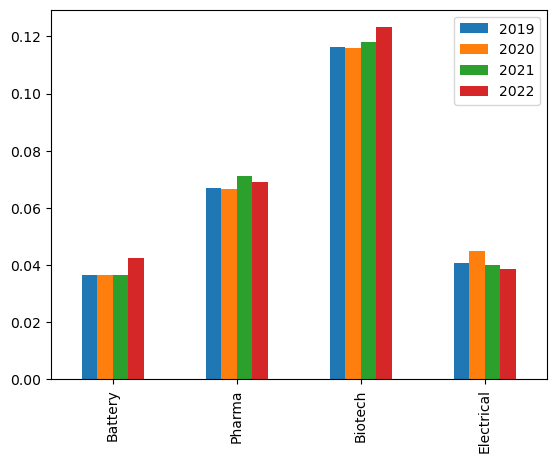

In [191]:
dists.iloc[:-1].plot(kind="bar")